# Data Visualization

## Specifications

This workflow should produce three publication-quality visualizations:

1. Daily-mean radiative fluxes at top of atmosphere and surface from ERA5 for 22 September 2020.
2. Intrinsic atmospheric radiative properties (reflectivity, absorptivity, and transmissivity) based on a simple model of reflected radiation.
3. Potential surface-reflected outgoing solar radiation, actual surface-reflected outgoing solar radiation, and their difference (gain).
4. Long-term mean of annual-mean solar radiation fluxes from ERA5, 1991–2020.
5. As in (4), but for the period overlapping with CERES EBAF, 2001–2020, with differences compared to (4).
6. As in (4), but for CERES EBAF, 2001–2020, with differences compared to (5).
7. As in (2), but based on CERES EBAF solar fluxes, with differences compared to (2).

Each figure should be rendered as a PNG and as a PDF file that can be converted to EPS for the publisher.

## Preliminaries

### Requirements

* A Google Cloud project with Cloud Storage enabled ([Create new account](https://cloud.google.com/))
* Python packages. See `environments` directory for platform and notebook specific environment files.

### Imports

In [1]:
from utils import check_environment

check_environment("visualize")

import logging
import os
import urllib.request

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from google.cloud import storage
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import xarray as xr

### Setup

In [2]:
data_dir = "../assets"

# Xarray configuration
xr.set_options(keep_attrs=True)

# Logging configuration
logging.basicConfig(filename="visualize.log", filemode="w", level=logging.INFO)

# Project ID
url = "http://metadata.google.internal/computeMetadata/v1/project/project-id"
req = urllib.request.Request(url)
req.add_header("Metadata-Flavor", "Google")
project_id = urllib.request.urlopen(req).read().decode()

## Functions

In [3]:
def get_data_gcs(bucket_name, file_name, file_path=".", user_project=None):
    """Download a dataset for a single date from Google Cloud Storage.
    
    Args:
        bucket_name: Google Cloud Storage bucket to download from.
        file_name: name of file to download from gcs.
        file_path: local path to download the file.
        user_project: project ID for requester pays billing.
    
    Returns:
        Nothing; downloads data from Google Cloud Storage.
    """
    if os.path.exists(os.path.join(file_path, file_name)):
        logging.info(f"{file_name} already exists locally; skipping GCS download.")
    else:
        client = storage.Client()
        bucket = client.bucket(bucket_name, user_project=user_project)    
        blob = bucket.blob(file_name)
        blob.download_to_filename(filename=os.path.join(file_path, file_name))
    

def plot_geodata(ax, lats, lons, data, levels, vmin, vmax, cmap, norm, title):
    """Visualize geographic data."""
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    
    ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), 
                  cmap=cmap, norm=norm, rasterized=True)
    ax.set_title(title)
    ax.coastlines("50m", linewidth=0.7)
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

## Workflow

### Download Data from GCS

In [4]:
get_data_gcs("era5-single-level-daily", "20200922.nc", data_dir, user_project=project_id)

In [5]:
get_data_gcs("rom-input", "rom_analysis.nc", data_dir, user_project=project_id)

In [6]:
get_data_gcs("rom-input", "rom_analysis_ceres_overlap.nc", data_dir, user_project=project_id)

In [7]:
get_data_gcs("rom-input", "rom_analysis_coarse.nc", data_dir, user_project=project_id)

In [8]:
get_data_gcs("rom-input", "rom_analysis_ceres.nc", data_dir, user_project=project_id)

### Figure 1: Schematic

Not shown here.

### Figure 2: Boundary Fluxes

1. Top of atmosphere incoming solar radiation
1. Surface downwelling solar radiation
1. Surface upwelling solar radiation
1. Top of atmosphere outgoing solar radiation

In [9]:
era5_daily = xr.open_dataset(os.path.join(data_dir, "20200922.nc"))

lons = era5_daily.longitude.data
lats = era5_daily.latitude.data
tisr = era5_daily.tisr.isel(time=0).data
ssrd = era5_daily.ssrd.isel(time=0).data
tosr = era5_daily.tosr.isel(time=0).data
ssru = era5_daily.ssru.isel(time=0).data

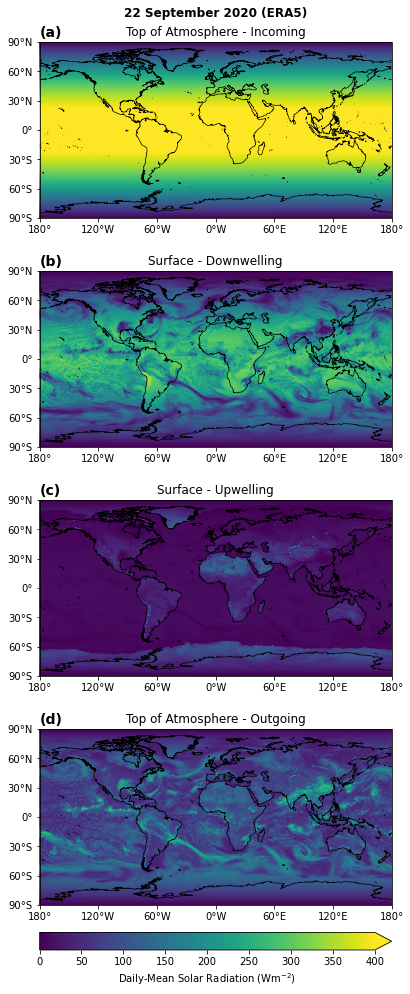

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(11,13), 
                        subplot_kw=dict(projection=ccrs.PlateCarree()))
cmap = cm.viridis
norm = colors.Normalize(vmin=0, vmax=400)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax4 = axs[3]

plot_geodata(ax1, lats, lons, tisr, 40, 0, 400, cmap, norm, "Top of Atmosphere - Incoming")
plot_geodata(ax2, lats, lons, ssrd, 40, 0, 400, cmap, norm, "Surface - Downwelling")
plot_geodata(ax3, lats, lons, ssru, 40, 0, 400, cmap, norm, "Surface - Upwelling")
plot_geodata(ax4, lats, lons, tosr, 40, 0, 400, cmap, norm, "Top of Atmosphere - Outgoing")

ax1.text(-180, 95, "(a)", fontsize=14, fontweight="bold")
ax2.text(-180, 95, "(b)", fontsize=14, fontweight="bold")
ax3.text(-180, 95, "(c)", fontsize=14, fontweight="bold")
ax4.text(-180, 95, "(d)", fontsize=14, fontweight="bold")

fig.tight_layout(pad=2.0)
fig.suptitle("22 September 2020 (ERA5)",
             y=0.999, fontweight="bold")

cax = inset_axes(ax4, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                    cax=cax, orientation="horizontal", extend="max")
cbar.ax.xaxis.set_ticks(np.arange(0, 401, 50), minor=True)
cbar.set_label("Daily-Mean Solar Radiation ($\mathrm{W m^{-2}}$)")

plt.savefig(os.path.join(data_dir, "ERC_Fig2.png"), 
            dpi=300, bbox_inches="tight", facecolor="white")
plt.savefig(os.path.join(data_dir, "ERC_Fig2.pdf"),
            dpi=300, bbox_inches="tight", facecolor="white")

### Figure 3: Intrinsic Atmospheric Radiative Properties

1. Reflectivity
2. Absorptivity
3. Transmissivity

In [11]:
rom_analysis = xr.open_dataset(os.path.join(data_dir, "rom_analysis.nc"))

lons = rom_analysis.longitude.data
lats = rom_analysis.latitude.data
reflectivity = rom_analysis.r.data
transmissivity = rom_analysis.t.data
absorptivity = rom_analysis.a.data

In [12]:
{"transmittance (min, max)": [transmissivity.min(), transmissivity.max()],
 "absorptance (min, max)": [absorptivity.min(), absorptivity.max()],
 "reflectance (min, max)": [reflectivity.min(), reflectivity.max()]}

{'transmittance (min, max)': [0.24501413, 0.799396],
 'absorptance (min, max)': [0.08102553, 0.28836644],
 'reflectance (min, max)': [0.085538544, 0.5801952]}

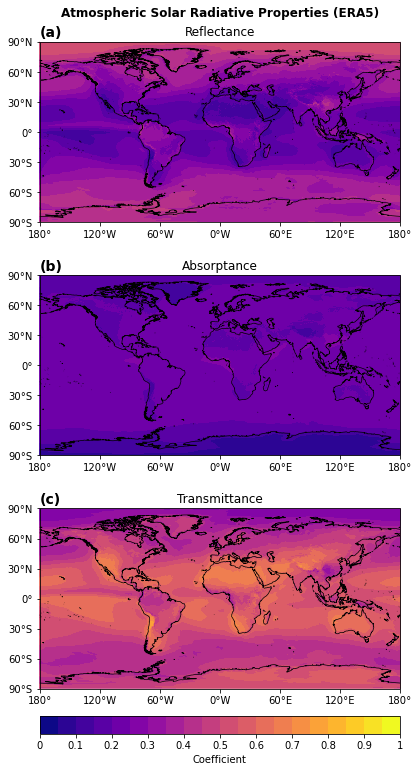

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(11,10), 
                        subplot_kw=dict(projection=ccrs.PlateCarree()))
cmap = cm.plasma
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
          0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

plot_geodata(ax1, lats, lons, reflectivity, levels, 0, 1, cmap, norm, "Reflectance")
plot_geodata(ax2, lats, lons, absorptivity, levels, 0, 1, cmap, norm, "Absorptance")
plot_geodata(ax3, lats, lons, transmissivity, levels, 0, 1, cmap, norm, "Transmittance")

ax1.text(-180, 95, "(a)", fontsize=14, fontweight="bold")
ax2.text(-180, 95, "(b)", fontsize=14, fontweight="bold")
ax3.text(-180, 95, "(c)", fontsize=14, fontweight="bold")

fig.tight_layout(pad=2.0)
fig.suptitle("Atmospheric Solar Radiative Properties (ERA5)",
             y=0.999, fontweight="bold")

cax = inset_axes(ax3, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                    cax=cax, orientation="horizontal")
cbar.ax.xaxis.set_ticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar.ax.xaxis.set_ticklabels(["0", "0.1", "0.2", "0.3", "0.4", "0.5", 
                              "0.6", "0.7", "0.8", "0.9", "1"])
cbar.set_label("Coefficient")

plt.savefig(os.path.join(data_dir, "ERC_Fig3.png"), 
            dpi=300, bbox_inches="tight",
            facecolor='white')
plt.savefig(os.path.join(data_dir, "ERC_Fig3.pdf"),
            dpi=300, bbox_inches="tight", 
            facecolor="white")

### Figure 4: Reflectivity Optimization Map

1. Potential surface-reflected outgoing solar radiation
2. Actual surface-reflected outgoing solar radiation
3. Difference (gain)

In [14]:
lons = rom_analysis.longitude.data
lats = rom_analysis.latitude.data
psrosr = rom_analysis.psrosr.data
srosr = rom_analysis.srosr.data
diff = (rom_analysis.psrosr.data - rom_analysis.srosr.data)

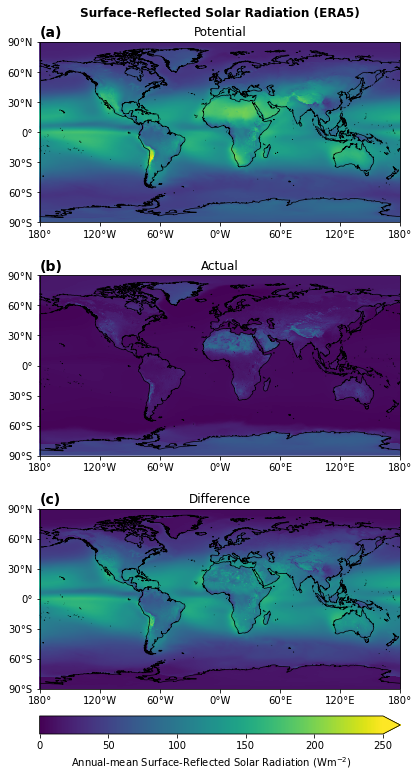

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(11,10), 
                        subplot_kw=dict(projection=ccrs.PlateCarree()))
cmap = cm.viridis
norm = colors.Normalize(vmin=0, vmax=250)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

plot_geodata(ax1, lats, lons, psrosr, 25, 0, 250, cmap, norm, "Potential")
plot_geodata(ax2, lats, lons, srosr, 25, 0, 250, cmap, norm, "Actual")
plot_geodata(ax3, lats, lons, diff, 25, 0, 250, cmap, norm, "Difference")

ax1.text(-180, 95, "(a)", fontsize=14, fontweight="bold")
ax2.text(-180, 95, "(b)", fontsize=14, fontweight="bold")
ax3.text(-180, 95, "(c)", fontsize=14, fontweight="bold")

fig.tight_layout(pad=2.0)
fig.suptitle("Surface-Reflected Solar Radiation (ERA5)",
             y=0.999, fontweight="bold")

cax = inset_axes(ax3, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                    cax=cax, orientation="horizontal", extend="max")
cbar.ax.xaxis.set_ticks(np.arange(0, 250, 50), minor=True)
cbar.set_label("Annual-mean Surface-Reflected Solar Radiation ($\mathrm{W m^{-2}}$)")

plt.savefig(os.path.join(data_dir, "ERC_Fig4.png"), 
            dpi=300, bbox_inches="tight",
            facecolor='white')
plt.savefig(os.path.join(data_dir, "ERC_Fig4.pdf"), 
            dpi=300, bbox_inches="tight",
            facecolor='white')

### Figure 5: ERA5 minus CERES (surface-reflected radiation)

In [16]:
rom_ceres = xr.open_dataset(os.path.join(data_dir, "rom_analysis_ceres.nc"))
rom_ceres = rom_ceres.rename({"latitude": "lat",
                              "longitude": "lon"})
rom_era5_coarse = xr.open_dataset(os.path.join(data_dir, "rom_analysis_coarse.nc"))

lons = rom_ceres.lon.data
lats = rom_ceres.lat.data
psrosr = rom_ceres.psrosr.data
srosr = rom_ceres.srosr.data
diff = (rom_ceres.psrosr.data - rom_ceres.srosr.data)

psrosr_d = (rom_era5_coarse - rom_ceres).psrosr
srosr_d = (rom_era5_coarse - rom_ceres).srosr
diff_d = (rom_era5_coarse - rom_ceres).psrosr - (rom_era5_coarse - rom_ceres).srosr

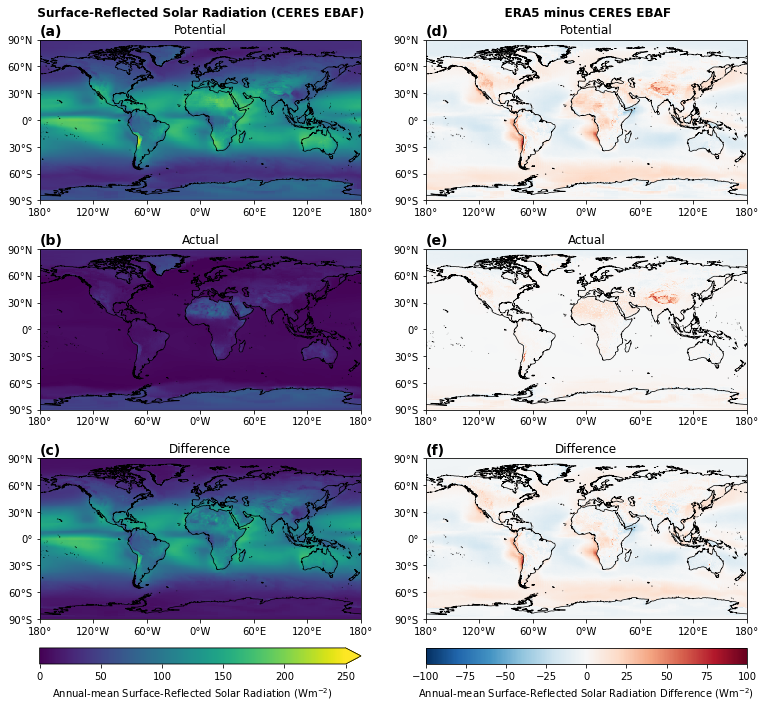

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(11,9),
                        subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax3 = axs[2, 0]
ax4 = axs[0, 1]
ax5 = axs[1, 1]
ax6 = axs[2, 1]

cmap_l = cm.viridis
norm_l = colors.Normalize(vmin=0, vmax=250)

plot_geodata(ax1, lats, lons, psrosr, 25, 0, 250, cmap_l, norm_l, "Potential")
plot_geodata(ax2, lats, lons, srosr, 25, 0, 250, cmap_l, norm_l, "Actual")
plot_geodata(ax3, lats, lons, diff, 25, 0, 250, cmap_l, norm_l, "Difference")

cmap_r = cm.RdBu_r
norm_r = colors.Normalize(vmin=-100, vmax=100)

plot_geodata(ax4, lats, lons, psrosr_d, 25, -100, 100, cmap_r, norm_r, "Potential")
plot_geodata(ax5, lats, lons, srosr_d, 25, -100, 100, cmap_r, norm_r, "Actual")
plot_geodata(ax6, lats, lons, diff_d, 25, -100, 100, cmap_r, norm_r, "Difference")

ax1.text(-180, 95, "(a)", fontsize=14, fontweight="bold")
ax2.text(-180, 95, "(b)", fontsize=14, fontweight="bold")
ax3.text(-180, 95, "(c)", fontsize=14, fontweight="bold")
ax4.text(-180, 95, "(d)", fontsize=14, fontweight="bold")
ax5.text(-180, 95, "(e)", fontsize=14, fontweight="bold")
ax6.text(-180, 95, "(f)", fontsize=14, fontweight="bold")

fig.tight_layout(pad=2.0)
_ = fig.suptitle("  Surface-Reflected Solar Radiation (CERES EBAF)          " + 
                 "                        ERA5 minus CERES EBAF                ",
                 y=0.999, fontweight="bold")

caxl = inset_axes(ax3, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar_l = fig.colorbar(cm.ScalarMappable(norm=norm_l, cmap=cmap_l), 
                      cax=caxl, orientation="horizontal", extend="max")
cbar_l.ax.xaxis.set_ticks(np.arange(0, 250, 50), minor=True)
cbar_l.set_label("Annual-mean Surface-Reflected Solar Radiation ($\mathrm{W m^{-2}}$)")

caxr = inset_axes(ax6, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar_r = fig.colorbar(cm.ScalarMappable(norm=norm_r, cmap=cmap_r),
                      cax=caxr, orientation="horizontal")
cbar_r.ax.xaxis.set_ticks(np.arange(-100, 100, 50), minor=True)
cbar_r.set_label("Annual-mean Surface-Reflected Solar Radiation Difference ($\mathrm{W m^{-2}}$)")

plt.savefig(os.path.join(data_dir, "ERC_Fig5.png"),
            dpi=300, bbox_inches="tight",
            facecolor='white')
plt.savefig(os.path.join(data_dir, "ERC_Fig5.pdf"),
            dpi=300, bbox_inches="tight",
            facecolor='white')

### Figure S1: ERA5 long-term mean fluxes

In [18]:
rom_analysis = xr.open_dataset(os.path.join(data_dir, "rom_analysis.nc"))

lons = rom_analysis.longitude.data
lats = rom_analysis.latitude.data
tisr = rom_analysis.tisr.data
ssrd = rom_analysis.ssrd.data
tosr = rom_analysis.tosr.data
ssru = rom_analysis.ssru.data

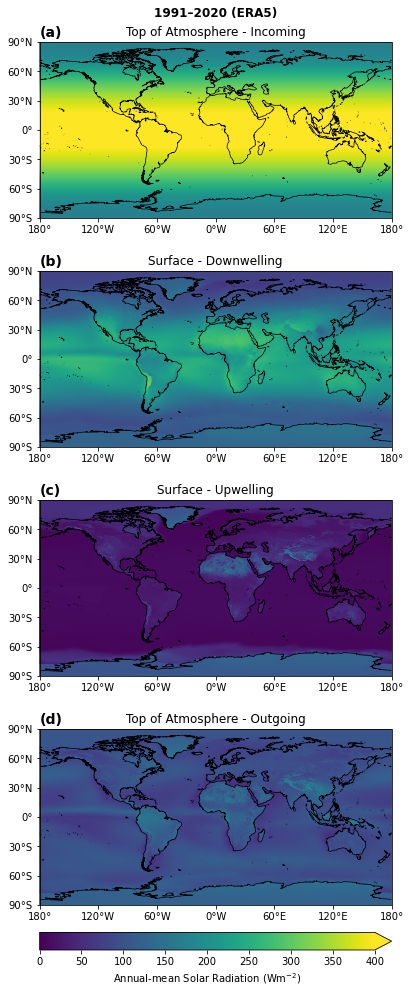

In [19]:
fig, axs = plt.subplots(4, 1, figsize=(11,13), 
                        subplot_kw=dict(projection=ccrs.PlateCarree()))
cmap = cm.viridis
norm = colors.Normalize(vmin=0, vmax=400)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax4 = axs[3]

plot_geodata(ax1, lats, lons, tisr, 40, 0, 400, cmap, norm, "Top of Atmosphere - Incoming")
plot_geodata(ax2, lats, lons, ssrd, 40, 0, 400, cmap, norm, "Surface - Downwelling")
plot_geodata(ax3, lats, lons, ssru, 40, 0, 400, cmap, norm, "Surface - Upwelling")
plot_geodata(ax4, lats, lons, tosr, 40, 0, 400, cmap, norm, "Top of Atmosphere - Outgoing")

ax1.text(-180, 95, "(a)", fontsize=14, fontweight="bold")
ax2.text(-180, 95, "(b)", fontsize=14, fontweight="bold")
ax3.text(-180, 95, "(c)", fontsize=14, fontweight="bold")
ax4.text(-180, 95, "(d)", fontsize=14, fontweight="bold")

fig.tight_layout(pad=2.0)
fig.suptitle("1991–2020 (ERA5)",
             y=0.999, fontweight="bold")

cax = inset_axes(ax4, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=cax, orientation="horizontal", extend="max")
cbar.ax.xaxis.set_ticks(np.arange(0, 401, 50), minor=True)
cbar.set_label("Annual-mean Solar Radiation ($\mathrm{W m^{-2}}$)")

plt.savefig(os.path.join(data_dir, "ERC_FigS1.png"), 
            dpi=300, bbox_inches="tight", facecolor="white")
plt.savefig(os.path.join(data_dir, "ERC_FigS1.pdf"), 
            dpi=300, bbox_inches="tight", facecolor="white")

### Figure S2: ERA5 long-term mean fluxes (2001-2020)

In [20]:
rom_analysis_o = xr.open_dataset(os.path.join(data_dir, "rom_analysis_ceres_overlap.nc"))

lons = rom_analysis_o.longitude.data
lats = rom_analysis_o.latitude.data

tisr_o = rom_analysis_o.tisr.data
ssrd_o = rom_analysis_o.ssrd.data
tosr_o = rom_analysis_o.tosr.data
ssru_o = rom_analysis_o.ssru.data

tisr_d = (rom_analysis - rom_analysis_o).tisr.data
ssrd_d = (rom_analysis - rom_analysis_o).ssrd.data
tosr_d = (rom_analysis - rom_analysis_o).tosr.data
ssru_d = (rom_analysis - rom_analysis_o).ssru.data

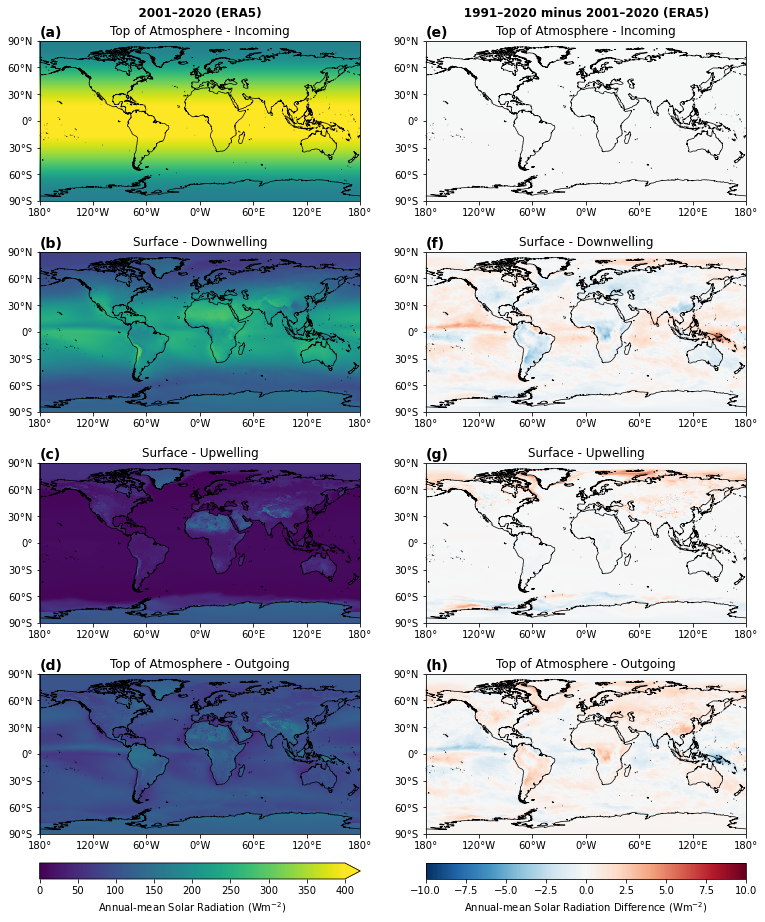

In [21]:
fig, axs = plt.subplots(4, 2, figsize=(11,12),
                        subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax3 = axs[2, 0]
ax4 = axs[3, 0]
ax5 = axs[0, 1]
ax6 = axs[1, 1]
ax7 = axs[2, 1]
ax8 = axs[3, 1]
          
cmap_l = cm.viridis
norm_l = colors.Normalize(vmin=0, vmax=400)

plot_geodata(ax1, lats, lons, tisr_o, 40, 0, 400, cmap_l, norm_l, "Top of Atmosphere - Incoming")
plot_geodata(ax2, lats, lons, ssrd_o, 40, 0, 400, cmap_l, norm_l, "Surface - Downwelling")
plot_geodata(ax3, lats, lons, ssru_o, 40, 0, 400, cmap_l, norm_l, "Surface - Upwelling")
plot_geodata(ax4, lats, lons, tosr_o, 40, 0, 400, cmap_l, norm_l, "Top of Atmosphere - Outgoing")

cmap_r = cm.RdBu_r
norm_r = colors.Normalize(vmin=-10, vmax=10)

plot_geodata(ax5, lats, lons, tisr_d, 20, -10, 10, cmap_r, norm_r, "Top of Atmosphere - Incoming")
plot_geodata(ax6, lats, lons, ssrd_d, 20, -10, 10, cmap_r, norm_r, "Surface - Downwelling")
plot_geodata(ax7, lats, lons, ssru_d, 20, -10, 10, cmap_r, norm_r, "Surface - Upwelling")
plot_geodata(ax8, lats, lons, tosr_d, 20, -10, 10, cmap_r, norm_r, "Top of Atmosphere - Outgoing")

ax1.text(-180, 95, "(a)", fontsize=14, fontweight="bold")
ax2.text(-180, 95, "(b)", fontsize=14, fontweight="bold")
ax3.text(-180, 95, "(c)", fontsize=14, fontweight="bold")
ax4.text(-180, 95, "(d)", fontsize=14, fontweight="bold")
ax5.text(-180, 95, "(e)", fontsize=14, fontweight="bold")
ax6.text(-180, 95, "(f)", fontsize=14, fontweight="bold")
ax7.text(-180, 95, "(g)", fontsize=14, fontweight="bold")
ax8.text(-180, 95, "(h)", fontsize=14, fontweight="bold")

fig.tight_layout(pad=2.0)
_ = fig.suptitle("                           2001–2020 (ERA5)          " + 
                 "                                       1991–2020 minus 2001–2020 (ERA5)       ",
                 y=0.999, fontweight="bold")

caxl = inset_axes(ax4, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar_l = fig.colorbar(cm.ScalarMappable(norm=norm_l, cmap=cmap_l), 
                      cax=caxl, orientation="horizontal", extend="max")
cbar_l.ax.xaxis.set_ticks(np.arange(0, 401, 50), minor=True)
cbar_l.set_label("Annual-mean Solar Radiation ($\mathrm{W m^{-2}}$)")

caxr = inset_axes(ax8, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar_r = fig.colorbar(cm.ScalarMappable(norm=norm_r, cmap=cmap_r),
                      cax=caxr, orientation="horizontal")
cbar_r.ax.xaxis.set_ticks(np.arange(-10, 10, 50), minor=True)
cbar_r.set_label("Annual-mean Solar Radiation Difference ($\mathrm{W m^{-2}}$)")

plt.savefig(os.path.join(data_dir, "ERC_FigS2.png"),
            dpi=300, bbox_inches="tight",
            facecolor='white')
plt.savefig(os.path.join(data_dir, "ERC_FigS2.pdf"),
            dpi=300, bbox_inches="tight",
            facecolor='white')

### Figure S3: ERA5 minus CERES (long-term mean solar fluxes)

In [22]:
lons = rom_ceres.lon.data
lats = rom_ceres.lat.data

tisr = rom_ceres.tisr.data
ssrd = rom_ceres.ssrd.data
tosr = rom_ceres.tosr.data
ssru = rom_ceres.ssru.data

tisr_d = (rom_era5_coarse - rom_ceres).tisr.data
ssrd_d = (rom_era5_coarse - rom_ceres).ssrd.data
tosr_d = (rom_era5_coarse - rom_ceres).tosr.data
ssru_d = (rom_era5_coarse - rom_ceres).ssru.data

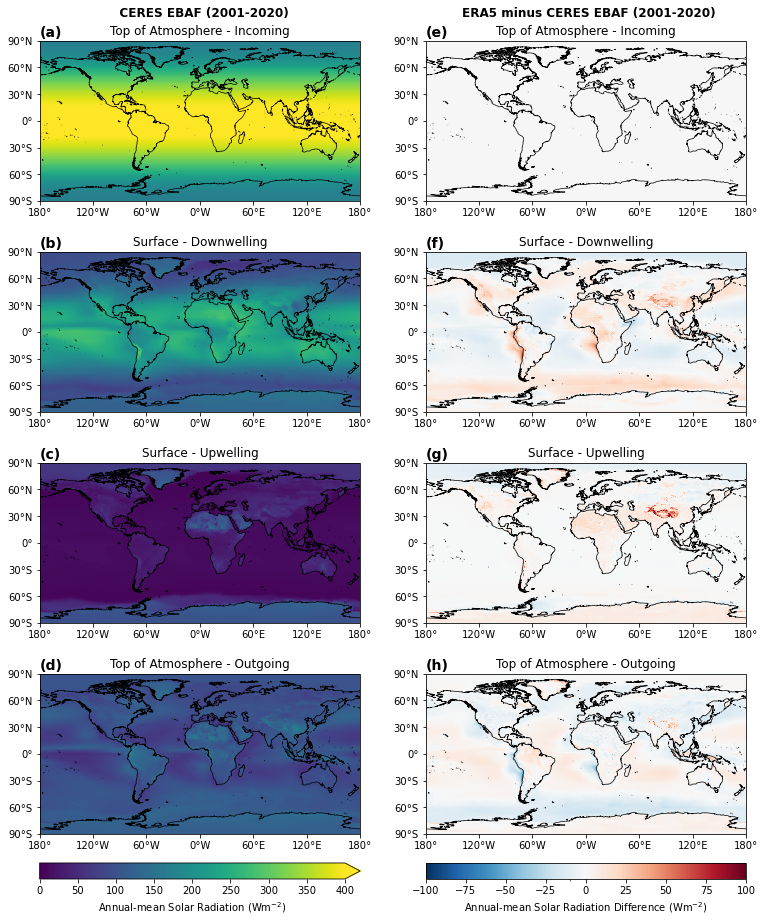

In [23]:
fig, axs = plt.subplots(4, 2, figsize=(11,12),
                        subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax3 = axs[2, 0]
ax4 = axs[3, 0]
ax5 = axs[0, 1]
ax6 = axs[1, 1]
ax7 = axs[2, 1]
ax8 = axs[3, 1]
          
cmap_l = cm.viridis
norm_l = colors.Normalize(vmin=0, vmax=400)

plot_geodata(ax1, lats, lons, tisr, 40, 0, 400, cmap_l, norm_l, "Top of Atmosphere - Incoming")
plot_geodata(ax2, lats, lons, ssrd, 40, 0, 400, cmap_l, norm_l, "Surface - Downwelling")
plot_geodata(ax3, lats, lons, ssru, 40, 0, 400, cmap_l, norm_l, "Surface - Upwelling")
plot_geodata(ax4, lats, lons, tosr, 40, 0, 400, cmap_l, norm_l, "Top of Atmosphere - Outgoing")

cmap_r = cm.RdBu_r
norm_r = colors.Normalize(vmin=-100, vmax=100)

plot_geodata(ax5, lats, lons, tisr_d, 20, -100, 100, cmap_r, norm_r, "Top of Atmosphere - Incoming")
plot_geodata(ax6, lats, lons, ssrd_d, 20, -100, 100, cmap_r, norm_r, "Surface - Downwelling")
plot_geodata(ax7, lats, lons, ssru_d, 20, -100, 100, cmap_r, norm_r, "Surface - Upwelling")
plot_geodata(ax8, lats, lons, tosr_d, 20, -100, 100, cmap_r, norm_r, "Top of Atmosphere - Outgoing")

ax1.text(-180, 95, "(a)", fontsize=14, fontweight="bold")
ax2.text(-180, 95, "(b)", fontsize=14, fontweight="bold")
ax3.text(-180, 95, "(c)", fontsize=14, fontweight="bold")
ax4.text(-180, 95, "(d)", fontsize=14, fontweight="bold")
ax5.text(-180, 95, "(e)", fontsize=14, fontweight="bold")
ax6.text(-180, 95, "(f)", fontsize=14, fontweight="bold")
ax7.text(-180, 95, "(g)", fontsize=14, fontweight="bold")
ax8.text(-180, 95, "(h)", fontsize=14, fontweight="bold")

fig.tight_layout(pad=2.0)
_ = fig.suptitle("                           CERES EBAF (2001-2020)         " + 
                 "                                 ERA5 minus CERES EBAF (2001-2020)          ",
                 y=0.999, fontweight="bold")

caxl = inset_axes(ax4, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar_l = fig.colorbar(cm.ScalarMappable(norm=norm_l, cmap=cmap_l), 
                      cax=caxl, orientation="horizontal", extend="max")
cbar_l.ax.xaxis.set_ticks(np.arange(0, 401, 50), minor=True)
cbar_l.set_label("Annual-mean Solar Radiation ($\mathrm{W m^{-2}}$)")

caxr = inset_axes(ax8, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar_r = fig.colorbar(cm.ScalarMappable(norm=norm_r, cmap=cmap_r),
                      cax=caxr, orientation="horizontal")
cbar_r.ax.xaxis.set_ticks(np.arange(-10, 10, 50), minor=True)
cbar_r.set_label("Annual-mean Solar Radiation Difference ($\mathrm{W m^{-2}}$)")

plt.savefig(os.path.join(data_dir, "ERC_FigS3.png"),
            dpi=300, bbox_inches="tight",
            facecolor='white')
plt.savefig(os.path.join(data_dir, "ERC_FigS3.pdf"),
            dpi=300, bbox_inches="tight",
            facecolor='white')

### Figure S4: ERA5 minus CERES (radiative properties)

In [24]:
lons = rom_ceres.lon.data
lats = rom_ceres.lat.data

transmissivity = rom_ceres.t.data
absorptivity = rom_ceres.a.data
reflectivity = rom_ceres.r.data

transmissivity_d = (rom_era5_coarse - rom_ceres).t
absorptivity_d = (rom_era5_coarse - rom_ceres).a
reflectivity_d = (rom_era5_coarse - rom_ceres).r

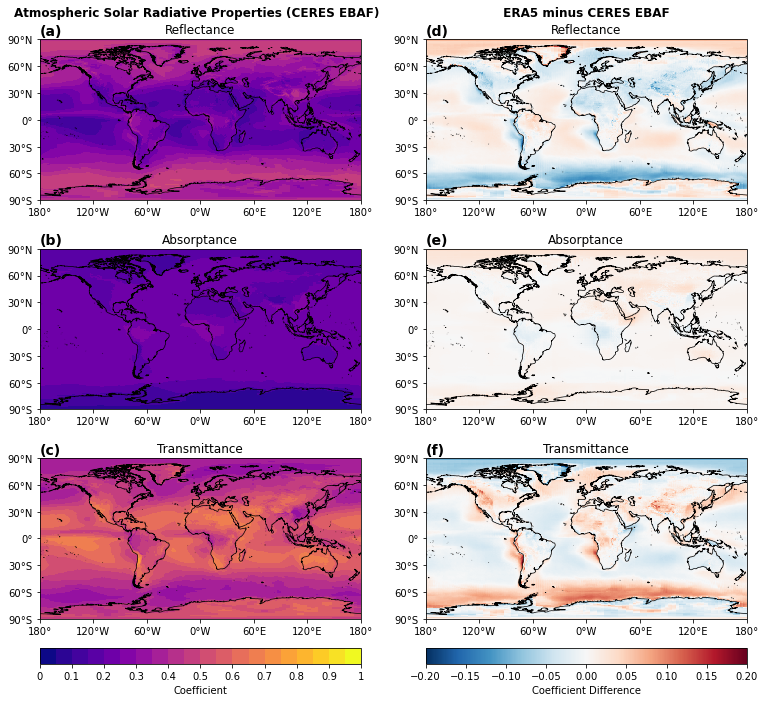

In [25]:
fig, axs = plt.subplots(3, 2, figsize=(11,9),
                        subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax3 = axs[2, 0]
ax4 = axs[0, 1]
ax5 = axs[1, 1]
ax6 = axs[2, 1]

cmap_l = cm.plasma
levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
          0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
norm_l = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

plot_geodata(ax1, lats, lons, reflectivity, levels, 0, 1, cmap_l, norm_l, "Reflectance")
plot_geodata(ax2, lats, lons, absorptivity, levels, 0, 1, cmap_l, norm_l, "Absorptance")
plot_geodata(ax3, lats, lons, transmissivity, levels, 0, 1, cmap_l, norm_l, "Transmittance")

cmap_r = cm.RdBu_r
norm_r = colors.Normalize(vmin=-0.2, vmax=0.2)

plot_geodata(ax4, lats, lons, reflectivity_d, 20, -0.2, 0.2, cmap_r, norm_r, "Reflectance")
plot_geodata(ax5, lats, lons, absorptivity_d, 20, -0.2, 0.2, cmap_r, norm_r, "Absorptance")
plot_geodata(ax6, lats, lons, transmissivity_d, 20, -0.2, 0.2, cmap_r, norm_r, "Transmittance")

ax1.text(-180, 95, "(a)", fontsize=14, fontweight="bold")
ax2.text(-180, 95, "(b)", fontsize=14, fontweight="bold")
ax3.text(-180, 95, "(c)", fontsize=14, fontweight="bold")
ax4.text(-180, 95, "(d)", fontsize=14, fontweight="bold")
ax5.text(-180, 95, "(e)", fontsize=14, fontweight="bold")
ax6.text(-180, 95, "(f)", fontsize=14, fontweight="bold")

fig.tight_layout(pad=2.0)
_ = fig.suptitle("Atmospheric Solar Radiative Properties (CERES EBAF)        " + 
                 "                      ERA5 minus CERES EBAF                    ",
                 y=0.999, fontweight="bold")

caxl = inset_axes(ax3, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar_l = fig.colorbar(cm.ScalarMappable(norm=norm_l, cmap=cmap_l), 
                      cax=caxl, orientation="horizontal")
cbar_l.ax.xaxis.set_ticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar_l.ax.xaxis.set_ticklabels(["0", "0.1", "0.2", "0.3", "0.4", "0.5",
                              "0.6", "0.7", "0.8", "0.9", "1"])
cbar_l.set_label("Coefficient")

caxr = inset_axes(ax6, width="100%", height="10%", loc="lower center", borderpad=-4.5)
cbar_r = fig.colorbar(cm.ScalarMappable(norm=norm_r, cmap=cmap_r),
                      cax=caxr, orientation="horizontal")
cbar_r.ax.xaxis.set_ticks(np.arange(-0.2, 0.2, 0.05), minor=True)
cbar_r.set_label("Coefficient Difference")

plt.savefig(os.path.join(data_dir, "ERC_FigS4.png"),
            dpi=300, bbox_inches="tight",
            facecolor='white')
plt.savefig(os.path.join(data_dir, "ERC_FigS4.pdf"),
            dpi=300, bbox_inches="tight",
            facecolor='white')

## Discussion

In this notebook we developed some publication-quality figures for a 
peer-reviewed journal article submitted to Environmental Research Communications. 
Additional material can be contributed to existing notebooks or new notebooks via 
a pull request.

The results of our analysis suggest geographic regions that have the greatest 
potential to reduce Earth's energy imbalance with surface reflectivity increaes. 
They are primarily in the tropics and subtropics. Some notable areas include the 
Andes, Southern Africa, coastal West Africa, southwestern North America, and Australia.

One limitation of our analysis is that we restricted our focus to the annual-mean energy 
budget. A practical reason to increase reflectivity near human habitations is to reduce 
heat and hence increase thermal comfort. From this perspective, reflectivity increases 
may help offset summertime heat. An analysis across the annual cycle could help identify
areas with seasonal reflectivity potential.

In [26]:
os.remove(os.path.join(data_dir, "20200922.nc"))
os.remove(os.path.join(data_dir, "rom_analysis.nc"))
os.remove(os.path.join(data_dir, "rom_analysis_coarse.nc"))
os.remove(os.path.join(data_dir, "rom_analysis_ceres.nc"))
os.remove(os.path.join(data_dir, "rom_analysis_ceres_overlap.nc"))